In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
# from rembg import remove
board_path = "Assignment/data/BOARDS/"
#待处理的图片路径
input_path = board_path+'BOARD'+'1'+'-'+'1'+'.jpg'
#处理后存储的图片路径
output_path = 'output.png'


In [3]:
import cv2

def crop_circuit_board(input_image_path, output_image_path):
    """
    This function takes an image of a circuit board with a simple background and crops out the circuit board,
    removing the background.
    
    :param input_image_path: str. The path to the input image containing the circuit board.
    :param output_image_path: str. The path where the cropped image will be saved.
    :return: None. The function saves the cropped image to the specified output path.
    """
    # Load the image
    img = cv2.imread(input_image_path)

    # Convert to grayscale and apply Gaussian blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)

    # Threshold the image to get a binary image
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming the largest contour is the circuit board, filter out small contours
    contours = [c for c in contours if cv2.contourArea(c) > 100]

    # Find the largest contour which will be the circuit board
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image to the bounding rect of the largest contour
    circuit_board = img[y:y+h, x:x+w]

    # Save the cropped image
    cv2.imwrite(output_image_path, circuit_board)

# Example usage:
# crop_circuit_board('path_to_input_image.jpg', 'path_to_output_image.png')


In [4]:
# Path
board_path = "Assignment/data/BOARDS/"

image_paths = []
images = []
images_grey = []
for i in range(3):
    index = str(i + 1)
    board_path_i = []
    image = []
    image_grey = []
    for j in range(3):
        jedex = str(j + 1)
        path = board_path+'BOARD'+index+'-'+jedex+'.jpg'
        input_path = path
        output_path = 'BOARD'+index+'-'+jedex+'.jpg'
        crop_circuit_board(input_path,output_path)
        path = output_path
        board_path_i.append(path)
        im = cv2.imread(path)
        image.append(im)
        grey = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        image_grey.append(grey)
    image_paths.append(board_path_i)
    images.append(image)
    images_grey.append(image_grey)

In [5]:
# Function to align images based on ORB features
def align_images(base_image, align_image):
    # Initialize ORB detector
    orb = cv2.ORB_create()
    # Find the keypoints and descriptors with ORB
    keypoints1, descriptors1 = orb.detectAndCompute(base_image, None)
    keypoints2, descriptors2 = orb.detectAndCompute(align_image, None)

    # Create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(descriptors1, descriptors2)

    # Sort them in the order of their distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

    # Use homography to warp image
    height, width = base_image.shape
    aligned_image = cv2.warpPerspective(align_image, h, (width, height))
    
    return aligned_image

In [6]:
def aligned_them(im1, im2, boardnum, imagenum):
    aligned = align_images(im1, im2)
    plt.imshow(aligned, cmap='gray')
    plt.title('Aligned BOARD'+str(boardnum)+' Image '+str(imagenum))
    plt.axis('off')
    plt.show()
    return aligned

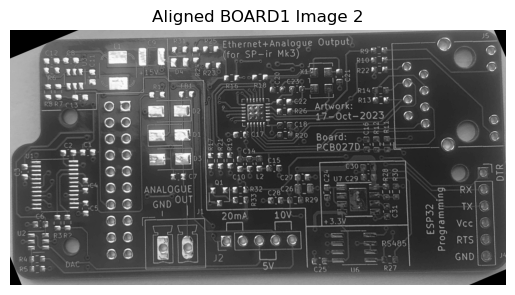

In [7]:
aligned_b1_image2 = aligned_them(images_grey[0][0],images_grey[0][1],1,2)

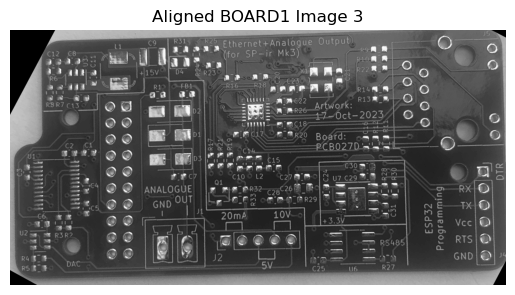

In [8]:
aligned_b1_image3 = aligned_them(images_grey[0][0],images_grey[0][2],1,3)

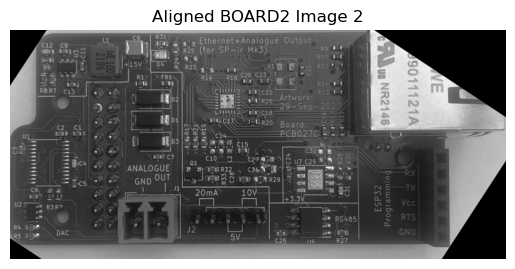

In [9]:
aligned_b2_image2 = aligned_them(images_grey[1][0],images_grey[1][1],2,2)

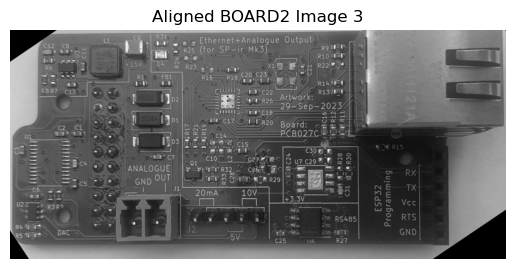

In [10]:
aligned_b2_image3 = aligned_them(images_grey[1][0],images_grey[1][2],2,3)

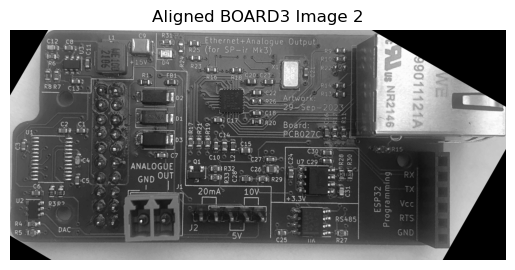

In [11]:
aligned_b3_image2 = aligned_them(images_grey[2][0],images_grey[2][1],3,2)

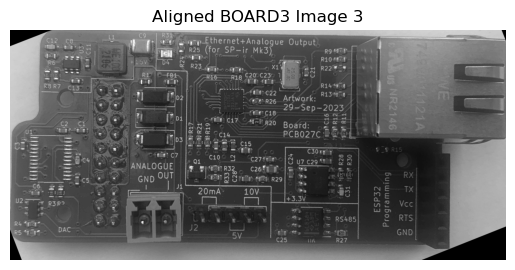

In [12]:
aligned_b3_image3 = aligned_them(images_grey[2][0],images_grey[2][2],3,3)

In [13]:
img_aligned = []
img_b1_aligned = [images_grey[0][0],aligned_b1_image2,aligned_b1_image3]
img_b2_aligned = [images_grey[1][0],aligned_b2_image2,aligned_b2_image3]
img_b3_aligned = [images_grey[2][0],aligned_b3_image2,aligned_b3_image3]
img_aligned.append(img_b1_aligned)
img_aligned.append(img_b2_aligned)
img_aligned.append(img_b3_aligned)

In [14]:
for i in range(len(img_aligned)):
    for j in range(len(img_aligned[i])):
        cv2.imwrite(str(i)+str(j)+".png", img_aligned[i][j])

In [15]:
# Average the two images by blending them together with equal weight
def average_images(img1, img2):
    """
    This function takes two images, converts them to the same size and mode if necessary,
    and returns a new image that is the average of the two.
    """
    # Ensure both images are the same size
    img1 = img1.resize(img2.size, Image.LANCZOS)

    # Ensure both images are in the same mode
    if img1.mode != img2.mode:
        img1 = img1.convert(img2.mode)

    # Blend the images together with equal weight to both
    return Image.blend(img1, img2, alpha=0.5)

In [16]:
# Load images again to ensure we're working with the original data
image1 = Image.open('00.png')
image2 = Image.open('01.png')
image3 = Image.open('02.png')

# Average the images
average_image = average_images(image2, image1)
average_image = average_images(average_image, image3)
# Save the averaged image
average_image_path = 'b1_averaged_image.png'
average_image.save(average_image_path)



In [17]:
# Load images again to ensure we're working with the original data
image1 = Image.open('10.png')
image2 = Image.open('11.png')
image3 = Image.open('12.png')

# Average the images
average_image = average_images(image2, image1)
average_image = average_images(average_image, image3)
# Save the averaged image
average_image_path = 'b2_averaged_image.png'
average_image.save(average_image_path)



In [18]:
# Load images again to ensure we're working with the original data
image1 = Image.open('20.png')
image2 = Image.open('21.png')
image3 = Image.open('22.png')

# Average the images
average_image = average_images(image2, image1)
# average_image = average_images(average_image, image1)
# Save the averaged image
average_image_path = 'b3_averaged_image.png'
average_image.save(average_image_path)

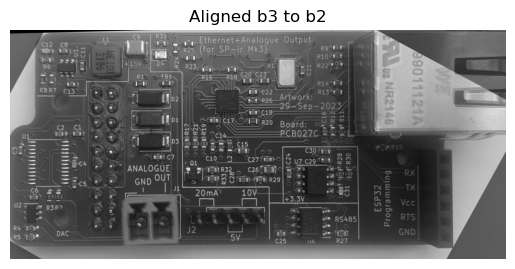

True

In [19]:
path = 'b2_averaged_image.png'
im = cv2.imread(path)
grey2 = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

path = 'b3_averaged_image.png'
im = cv2.imread(path)
grey3 = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

aligned_b3_to_b2 = align_images(grey2, grey3)

plt.imshow(aligned_b3_to_b2, cmap='gray')
plt.title('Aligned b3 to b2')
plt.axis('off')
plt.show()

cv2.imwrite("b3_avg_aligned.png", aligned_b3_to_b2)

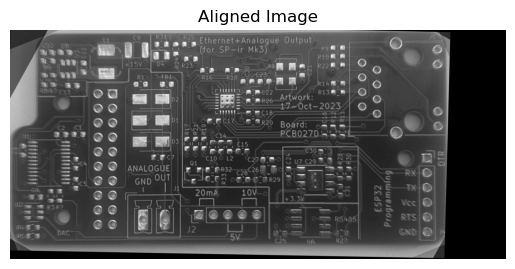

'b1_avg_aligned.png'

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
base_image_path = 'b2_averaged_image.png'
align_image_path = 'b1_averaged_image.png'
base_image = cv2.imread(base_image_path, cv2.IMREAD_GRAYSCALE)
align_image = cv2.imread(align_image_path, cv2.IMREAD_GRAYSCALE)

# Check if images are loaded correctly
if base_image is None or align_image is None:
    raise ValueError("Could not load the images!")

# Initialize SIFT detector
sift = cv2.SIFT_create()
# Find the keypoints and descriptors with SIFT
keypoints1, descriptors1 = sift.detectAndCompute(base_image, None)
keypoints2, descriptors2 = sift.detectAndCompute(align_image, None)

# Create FLANN matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Match descriptors using KNN
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Store all the good matches as per Lowe's ratio test.
good_matches = []
for m, n in matches:
    if m.distance < 0.7*n.distance:
        good_matches.append(m)

# Extract location of good matches
points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
points2 = np.zeros((len(good_matches), 2), dtype=np.float32)

for i, match in enumerate(good_matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Use homography to warp image
height, width = base_image.shape
aligned_image = cv2.warpPerspective(align_image, h, (width, height))

# Save the aligned image
aligned_image_path = 'b1_avg_aligned.png'
cv2.imwrite(aligned_image_path, aligned_image)

# Display the aligned image
plt.imshow(aligned_image, cmap='gray')
plt.title('Aligned Image')
plt.axis('off')
plt.show()

# Output the path to the aligned image
aligned_image_path


In [21]:
from skimage.io import imread

# Load an image
image_path = 'b3_avg_aligned.png'  # Replace with the path to your image
image = imread(image_path)

# Determine the number of channels
if image.ndim == 2:
    channels = 1  # Grayscale image
elif image.shape[2] == 3:
    channels = 3  # RGB image
elif image.shape[2] == 4:
    channels = 4  # RGBA image

print(f"The image has {channels} channels.")


D:\ProgramData\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


The image has 1 channels.


In [22]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, measure
from scipy.ndimage import label
# 假设b1、b2、b3图像已经正确加载到变量b1_img、b2_img、b3_img中。

# 计算b3和b2之间的差异，即寻找在b3中但不在b2中的元素
diff_b3_b2 = np.abs(b3_img_float - b2_img_float)

# 计算b2和b1之间的差异，即b2与空白板之间的不同
diff_b2_b1 = np.abs(b2_img_float - b1_img_float)

# 修正b3和b2之间的差异，减去b2和b1之间的差异
# 这样做的目的是只保留b3中独有的元素，而忽略b2中已有的元素
diff_corrected = diff_b3_b2 - diff_b2_b1

# 阈值化修正后的差异图像
threshold_value = np.max(diff_corrected) * 0.05  # 设定阈值为最大差异的5%
diff_thresholded = diff_corrected > threshold_value

# 应用形态学开运算来移除小对象
selem = morphology.square(3)  # 创建一个3x3的结构元素
diff_thresholded_opened = morphology.opening(diff_thresholded, selem)

# 应用形态学闭运算来突出显示连续区域
selem = morphology.rectangle(5, 5)  # 创建一个5x5的矩形结构元素
diff_thresholded_closed = morphology.closing(diff_thresholded_opened, selem)

# 使用连通组件分析来识别大面积的差异
labeled_array, num_features = label(diff_thresholded_closed)
object_areas = [np.sum(labeled_array == i) for i in range(1, num_features + 1)]
large_objects = np.isin(labeled_array, [i for i, area in enumerate(object_areas, start=1) if area > 50])  # 假设大于50个像素的为大对象

# 准备高亮显示的图像，只包含大的正方形或长方形的零件
highlighted_large_objects = np.zeros(b3_img.shape + (3,))
highlighted_large_objects[..., 0] = large_objects  # 红色通道表示大的差异
highlighted_large_objects[..., 1] = b3_img_float / np.max(b3_img_float)  # 绿色和蓝色通道显示b3板图像
highlighted_large_objects[..., 2] = b3_img_float / np.max(b3_img_float)

# # 准备高亮显示的图像
# highlighted = np.zeros(b3_img.shape + (3,))
# highlighted[..., 0] = diff_thresholded  # 红色通道表示差异
# highlighted[..., 1] = b3_img_float / np.max(b3_img_float)  # 绿色和蓝色通道显示b3板图像
# highlighted[..., 2] = b3_img_float / np.max(b3_img_float)

# 显示图像
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(b1_img, cmap='gray')
axes[0].set_title('Board 1 (Empty)')
axes[0].axis('off')

axes[1].imshow(b2_img, cmap='gray')
axes[1].set_title('Board 2 (Missing Components)')
axes[1].axis('off')

axes[2].imshow(b3_img, cmap='gray')
axes[2].set_title('Board 3 (Full)')
axes[2].axis('off')

axes[3].imshow(highlighted)
axes[3].set_title('Differences Highlighted')
axes[3].axis('off')

plt.tight_layout()
plt.show()


NameError: name 'b3_img_float' is not defined

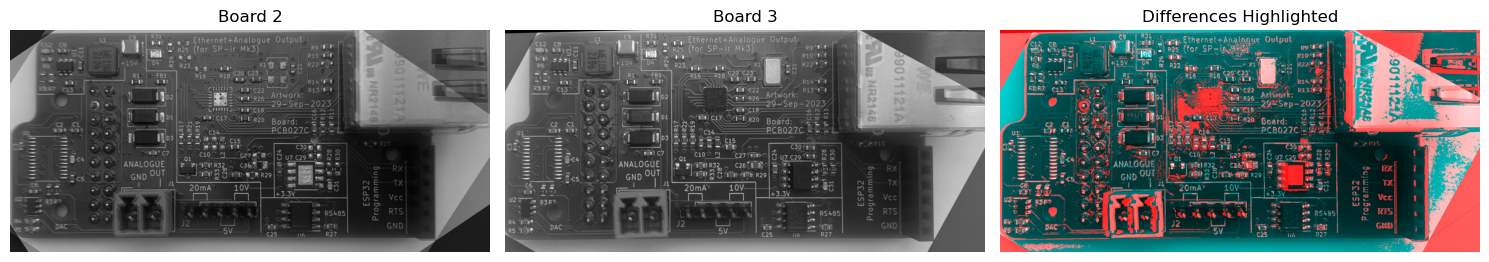

In [23]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

# Load the images directly as grayscale
board2_img = imread('b2_averaged_image.png')  # Replace with your image path
board3_img = imread('b3_avg_aligned.png')  # Replace with your image path

# Convert images to float for processing
board2_img_float = board2_img.astype('float64')
board3_img_float = board3_img.astype('float64')

# Compute the absolute difference between the two images
difference = np.abs(board3_img_float - board2_img_float)

# Normalize the difference image to the range [0, 1] for display purposes
difference_normalized = (difference - np.min(difference)) / (np.max(difference) - np.min(difference))

# Apply a threshold to the normalized difference to highlight significant differences
threshold_value = 0.1  # This can be adjusted based on your specific case
difference_thresholded = difference_normalized > threshold_value

# Prepare the highlighted image
highlighted = np.zeros(board3_img.shape + (3,))
highlighted[..., 0] = difference_thresholded  # Red channel
highlighted[..., 1] = board3_img_float / np.max(board3_img_float)  # Green channel
highlighted[..., 2] = board3_img_float / np.max(board3_img_float)  # Blue channel

# Display the original images and the difference
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(board2_img, cmap='gray')
axes[0].set_title('Board 2')
axes[0].axis('off')

axes[1].imshow(board3_img, cmap='gray')
axes[1].set_title('Board 3')
axes[1].axis('off')

# Highlight the differences in red on the BOARD3 image
axes[2].imshow(highlighted)
axes[2].set_title('Differences Highlighted')
axes[2].axis('off')

plt.tight_layout()
plt.show()
